We are not using test data splits but do all feature importance directly on the training data. 

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context('notebook')

np.random.seed(42)

# Load dataframe
data = pd.read_csv('simulated_data.csv')

# Plot simulated data

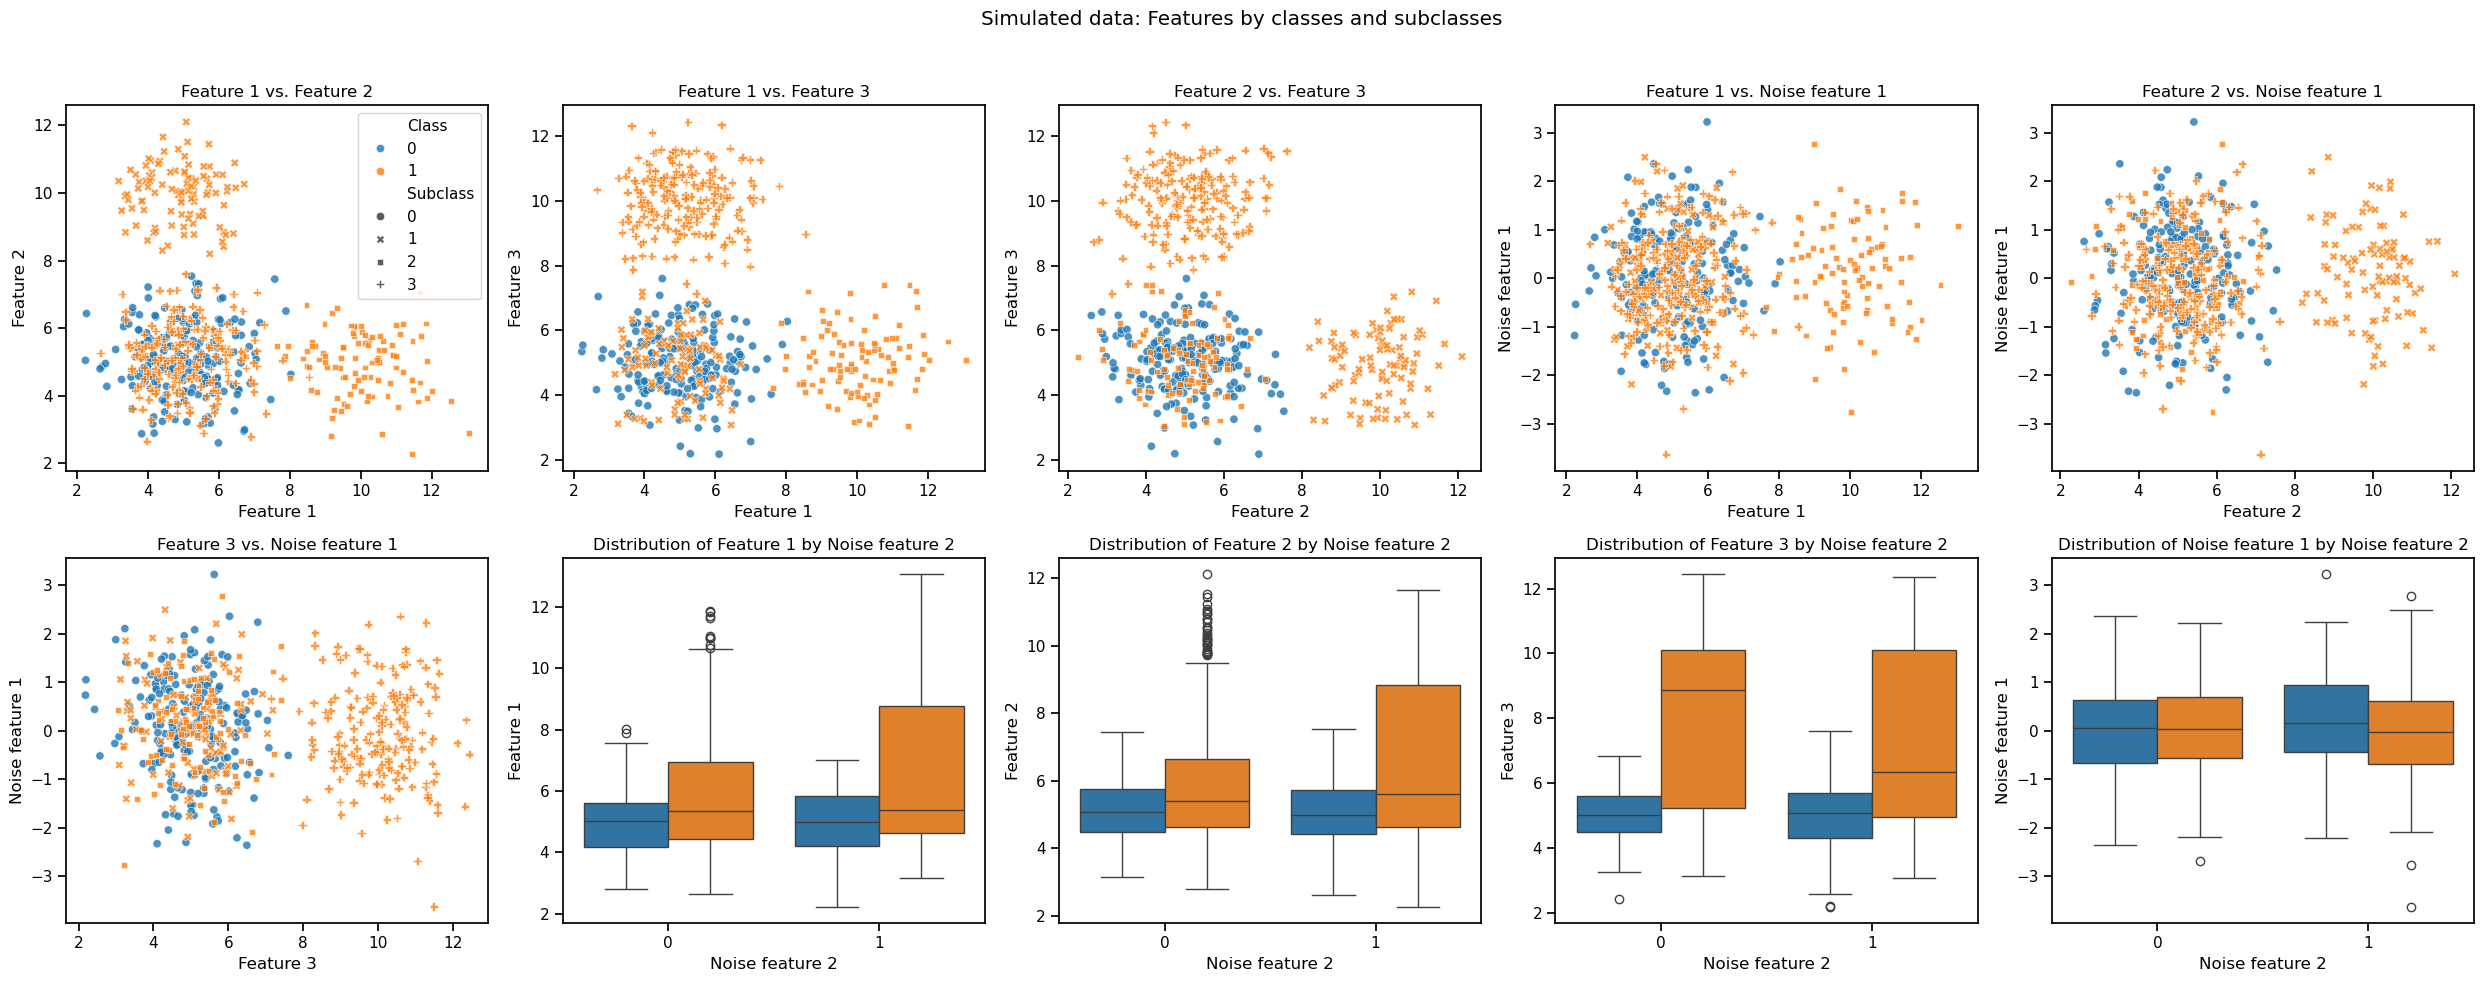

In [2]:
plot_data = data.copy()

feature_pairs = [
    ('Feature_1', 'Feature_2'),
    ('Feature_1', 'Feature_3'),
    ('Feature_2', 'Feature_3'),
    ('Feature_1', 'Noise_feature_1'),
    ('Feature_2', 'Noise_feature_1'),
    ('Feature_3', 'Noise_feature_1'),
    ('Feature_1', 'Noise_feature_2'),
    ('Feature_2', 'Noise_feature_2'),
    ('Feature_3', 'Noise_feature_2'),
    ('Noise_feature_1', 'Noise_feature_2')
]

# Create a 2x5 grid for the 10 plots
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig.suptitle('Simulated data: Features by classes and subclasses')

# Loop through all axes and feature pairs
for i, (ax, (x_feat, y_feat)) in enumerate(zip(axes.flatten(), feature_pairs)):

    if 'Noise_feature_2' in (x_feat, y_feat):
        
        # For a boxplot, the binary feature should be on the x-axis
        if x_feat == 'Noise_feature_2':
            boxplot_x, boxplot_y = x_feat, y_feat
        else:
            boxplot_x, boxplot_y = y_feat, x_feat # Swap them

        sns.boxplot(
            data=plot_data,
            x=boxplot_x,
            y=boxplot_y,
            hue='Class',
            ax=ax
        )
        
        ax.set_title(f'Distribution of {boxplot_y.replace("_"," ")} by {boxplot_x.replace("_"," ")}')
        ax.set_xlabel(boxplot_x.replace('_', ' '))
        ax.set_ylabel(boxplot_y.replace('_', ' '))

    else:
        sns.scatterplot(
            data=plot_data,
            x=x_feat,
            y=y_feat,
            hue='Class',
            style='Subclass',
            alpha=0.8,
            ax=ax
        )
        ax.set_title(f'{x_feat.replace("_"," ")} vs. {y_feat.replace("_"," ")}')
        ax.set_xlabel(x_feat.replace('_', ' '))
        ax.set_ylabel(y_feat.replace('_', ' '))

    if i > 0: # Remove legend from all but the first plot
        if ax.get_legend() is not None:
            ax.get_legend().remove()


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/05_simulated_data.png', dpi=900)
plt.show()

# Correlation of simulated data

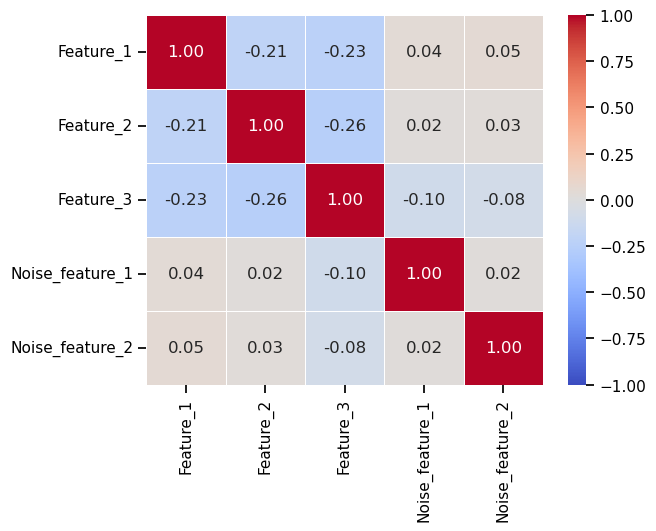

In [3]:
corr = data.drop(columns=['Subclass', 'Class']).corr(method='pearson')

plt.figure()
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.5, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Run Random Forest

Applying a general Random Forest to classify the two classes (`Combined_Class`). 

In [4]:
# Select only two classes
data_combined = data.drop('Subclass', axis=1)

X = data_combined.drop('Class', axis=1)
y = data_combined.Class

In [5]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 3], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X, y)
rf = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 3, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.987


# Apply FGC

Use FGC to classify the two classes (`Combined_Class`). In the feature importance, we see that for cluster 1 only feature 2 is relevant while for cluster 2 both are relevant. The global feature importance also shows equal importance of the two features. 

In [6]:
from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_feature_importance, 
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
)

fgc = forest_guided_clustering(
    estimator=rf, 
    X=X, 
    y=y, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam", max_iter=200)
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [01:48<00:00, 21.62s/it]


Optimal number of clusters k = 4

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                              Cluster_JI
 2 0.229837    True    1.000                                        {1: 1.0, 2: 1.0}
 3 0.110089    True    0.990                            {1: 0.99, 2: 0.999, 3: 0.98}
 4 0.017201    True    1.000                        {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}
 5 0.021259    True    0.974          {1: 0.992, 2: 0.959, 3: 1.0, 4: 1.0, 5: 0.917}
 6 0.018069    True    0.914 {1: 0.715, 2: 0.964, 3: 0.935, 4: 0.87, 5: 1.0, 6: 1.0}


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 244.09it/s]


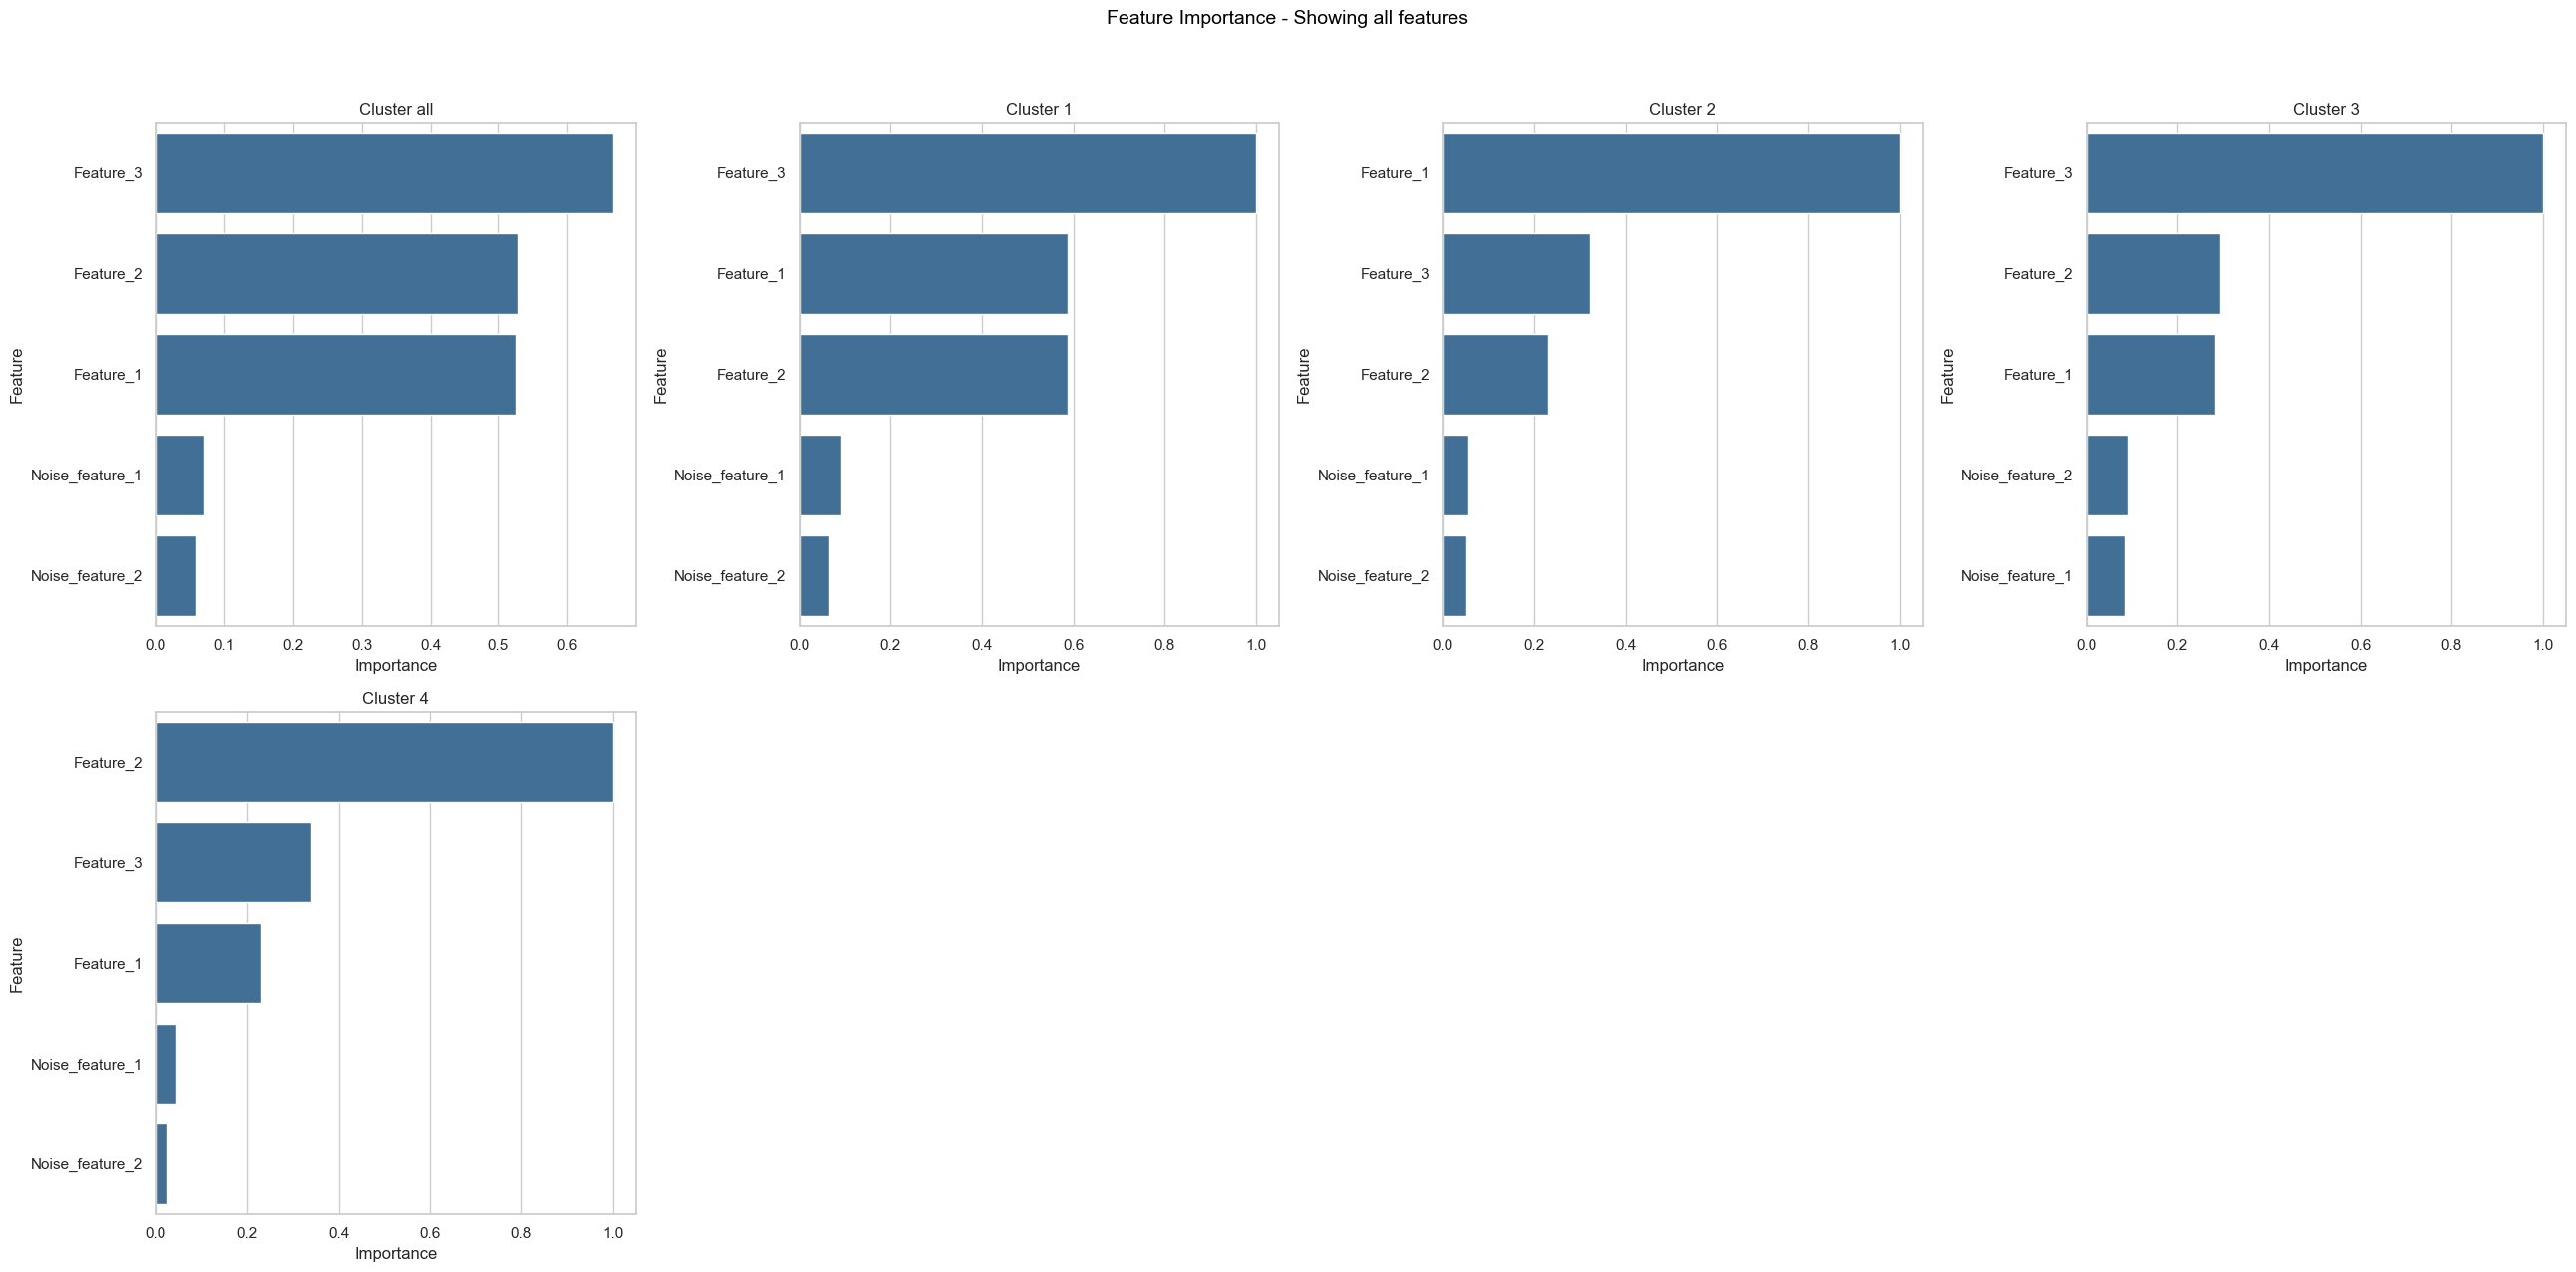

In [7]:
feature_importance = forest_guided_feature_importance(
    X=data_combined, 
    y="Class", 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="wasserstein",
)

plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global
)

## FGC decision paths

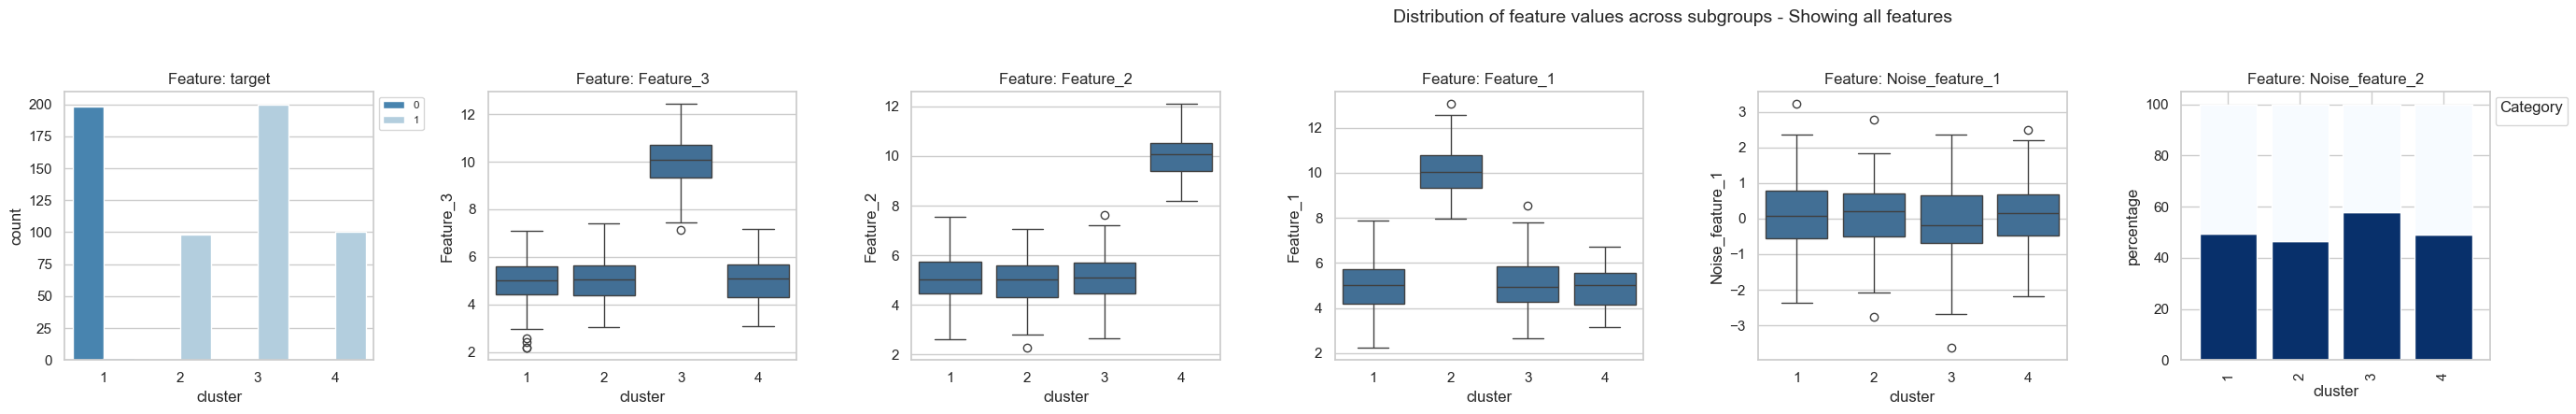

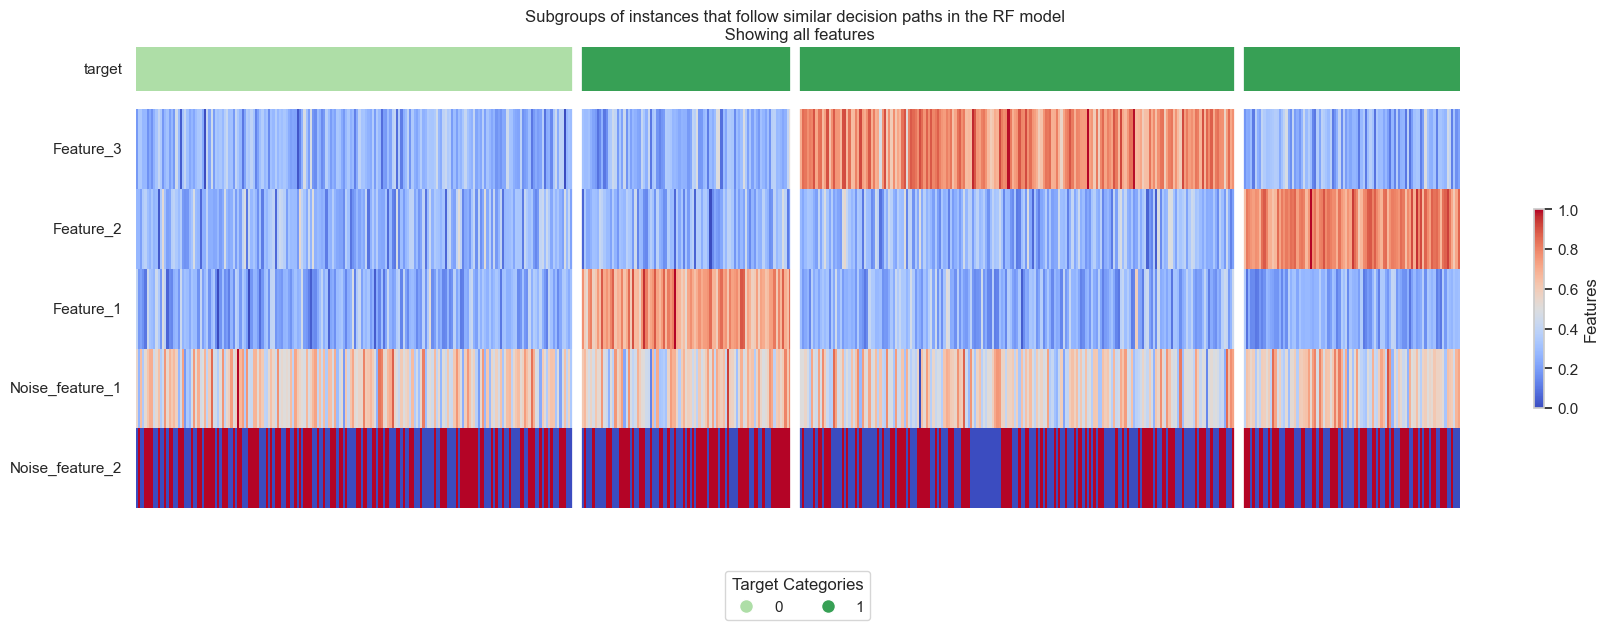

In [8]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=8, 
    save='figures/03_simulated_data'
)


## Scatterplots of features by FGC clusters

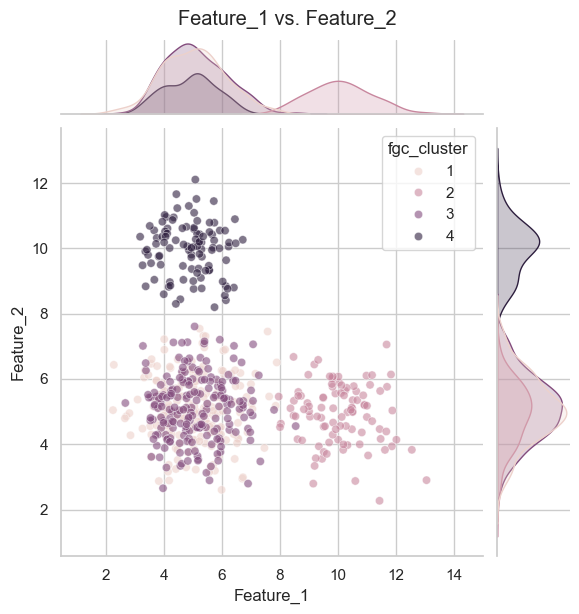

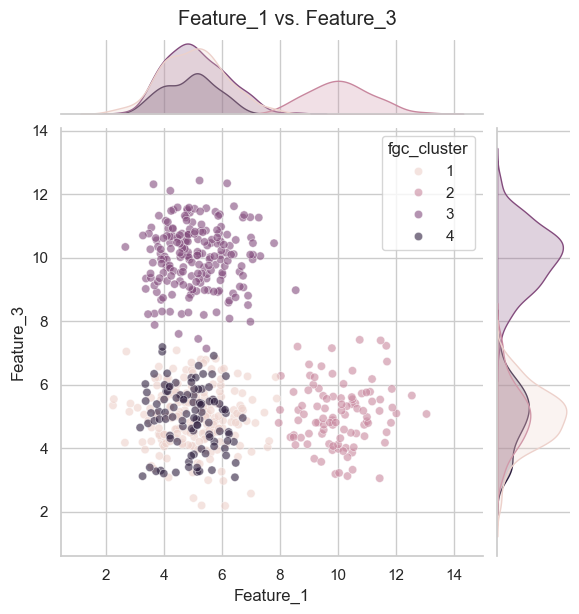

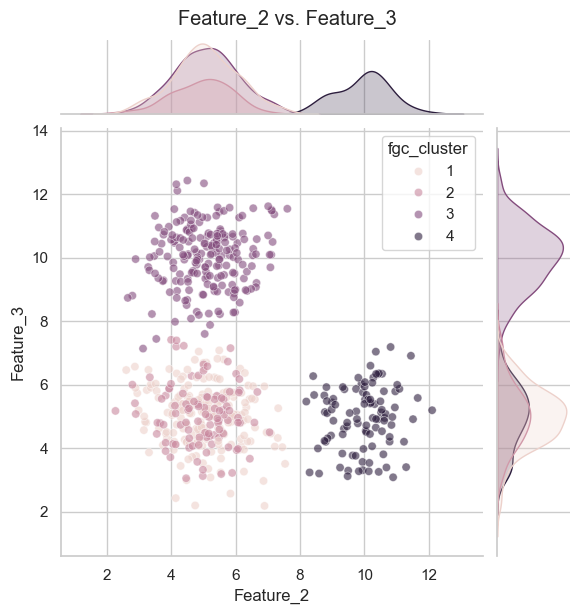

In [9]:
data['fgc_cluster'] = fgc.cluster_labels
# Define combinations
feature_pairs = [
    ('Feature_1', 'Feature_2'),
    ('Feature_1', 'Feature_3'),
    ('Feature_2', 'Feature_3')
]

# Create separate jointplots and access their figures
plots = []
for x_feat, y_feat in feature_pairs:
    g = sns.jointplot(
        data=data, x=x_feat, y=y_feat, hue='fgc_cluster', kind='scatter',
        alpha=0.6
    )
    g.fig.suptitle(f'{x_feat} vs. {y_feat}', y=1.02)
    plots.append(g)

plt.show()

# Apply Mean Decrease in Impurity (MDI) Feature Importance

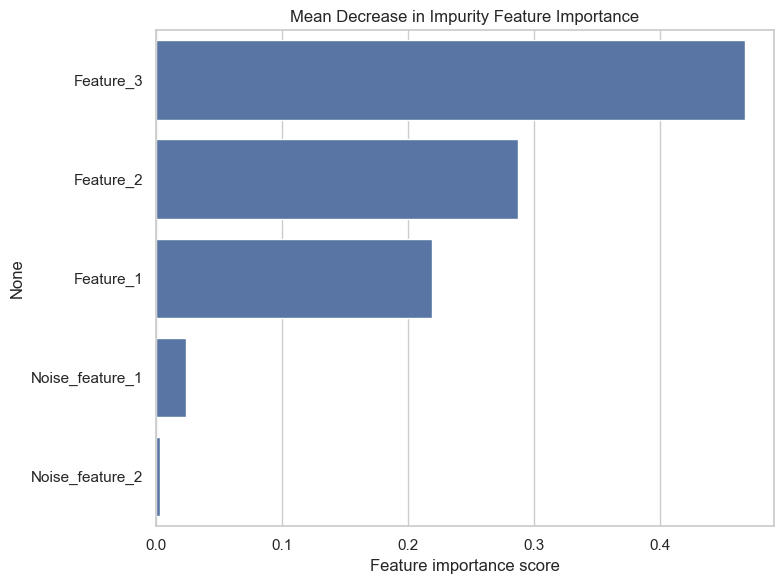

In [10]:
mdi_scores = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
# Plot scores
fig_mdi, ax_mdi = plt.subplots(figsize=(8, 6))
sns.barplot(x=mdi_scores, y=mdi_scores.index, ax=ax_mdi)
ax_mdi.set_xlabel('Feature importance score')
ax_mdi.set_title('Mean Decrease in Impurity Feature Importance')
fig_mdi.tight_layout()

# Apply Permutation Feature Importance

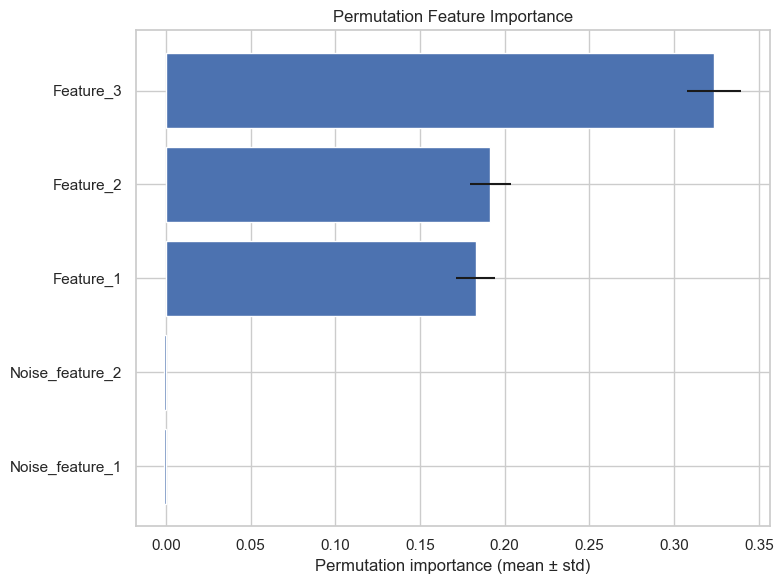

In [11]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_result = permutation_importance(rf, X, y, n_repeats=50, max_samples=0.8, random_state=42)

# Prepare data
perm_scores = pd.Series(perm_result.importances_mean, index=X.columns)
perm_errors = pd.Series(perm_result.importances_std, index=X.columns)
perm_scores = perm_scores.sort_values(ascending=True)  # ascending for horizontal bars
perm_errors = perm_errors[perm_scores.index]  # match order

# Plot with error bars
fig_perm, ax_perm = plt.subplots(figsize=(8, 6))
ax_perm.barh(perm_scores.index, perm_scores.values, xerr=perm_errors.values)
ax_perm.set_xlabel('Permutation importance (mean ± std)')
ax_perm.set_title('Permutation Feature Importance')
fig_perm.tight_layout()

# TreeSHAP
Applied on all of our observations (no test data!)

## Summary plot of SHAP values for formula raw predictions for class 0

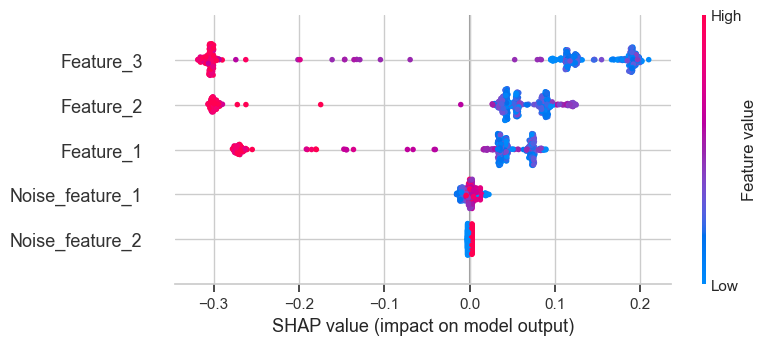

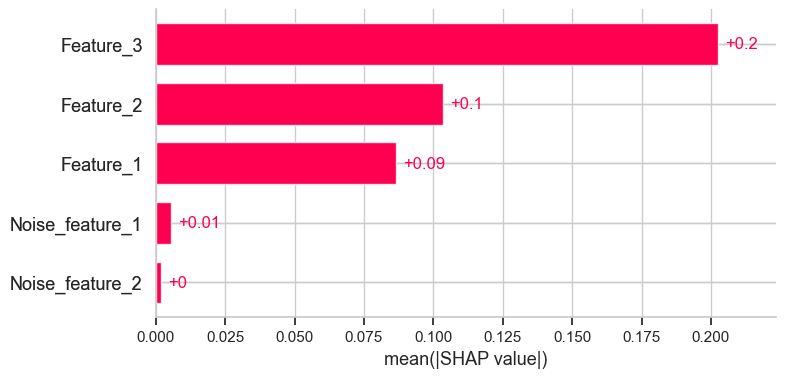

None
None


In [12]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X)

shap_beeswarm_class0 = shap.plots.beeswarm(shap_values[..., 0])
shap_summary_class0 = shap.plots.bar(shap_values[:,:,0])

print(shap_beeswarm_class0)
print(shap_summary_class0)

# Lime

C:\Users\GregorMiller\miniforge3\envs\fgc_dev\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\GregorMiller\miniforge3\envs\fgc_dev\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\GregorMiller\miniforge3\envs\fgc_dev\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\GregorMiller\miniforge3\envs\fgc_dev\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\GregorMiller\miniforge3\envs\fgc_dev\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X

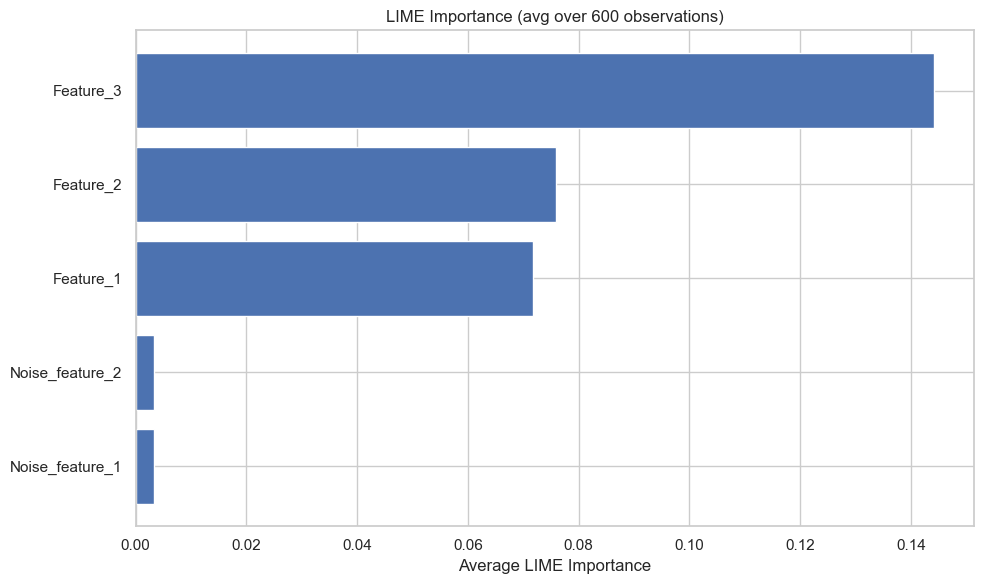

In [13]:
import lime
import lime.lime_tabular

feature_names = X.columns.tolist()
class_names = [str(c) for c in np.unique(y)]

# Initialize the lime explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Initialize score container
lime_scores = pd.Series(0.0, index=feature_names)

# Loop over all observations
for i in range(X.shape[0]):
    exp = lime_explainer.explain_instance(
        data_row=X.iloc[i].values,
        predict_fn=rf.predict_proba,
        num_features=len(feature_names)
    )
    for feat, val in exp.as_list():
        parsed_feat = feat.split(' ')[0]
        if parsed_feat in lime_scores:
            lime_scores[parsed_feat] += abs(val)

# Average over all observations
lime_importance = lime_scores / X.shape[0]

# Sort and plot
lime_sorted = lime_importance.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(lime_sorted.index, lime_sorted.values)
plt.xlabel("Average LIME Importance")
plt.title(f"LIME Importance (avg over {X.shape[0]} observations)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Comparison clustering methods

In [14]:
import kmedoids
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import adjusted_rand_score

# K-medoids with scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
dist_matrix = euclidean_distances(X_scaled)
kmedoids_labels = kmedoids.fasterpam(dist_matrix, medoids=4, random_state=15, max_iter=200).labels

# Load unsupervised RF clustering labels
unsup_rf_labels = pd.read_csv('unsupervised_RF_clusters.csv')
unsup_rf_labels = unsup_rf_labels.x

--- KMedoids vs. Ground Truth Subclass ---
Subclass    0   1   2    3
row_0                     
0          96  49  10    7
1         100  51   0   69
2           1   0  90    0
3           3   0   0  124

--- Unsupervised RF vs. Ground Truth Subclass ---
Subclass    0   1   2    3
x                         
1         151  53  32   37
2          46   1  13  163
3           2   0  55    0
4           1  46   0    0

--- FGC vs. Ground Truth Subclass ---
Subclass    0    1   2    3
row_0                      
1         198    0   2    0
2           1    0  98    0
3           1    0   0  200
4           0  100   0    0


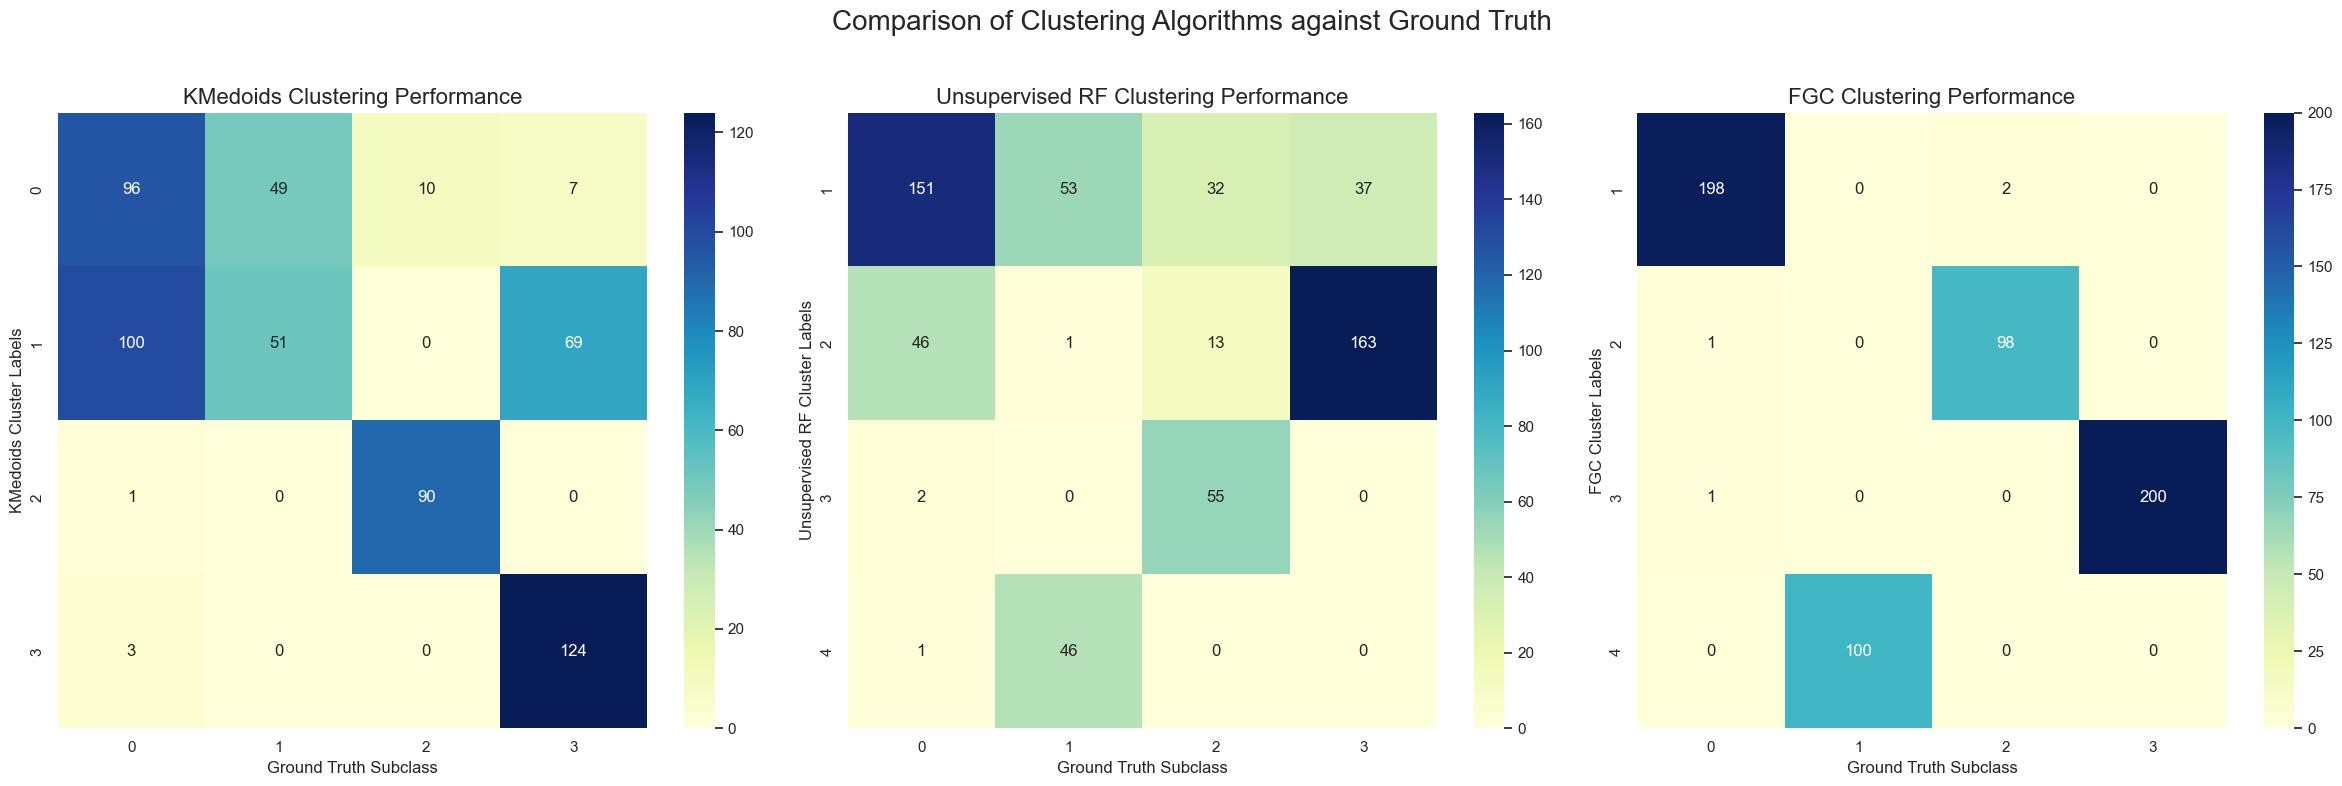

In [15]:
contingency_fgc = pd.crosstab(fgc.cluster_labels, data['Subclass'])
contingency_kmedoids = pd.crosstab(kmedoids_labels, data['Subclass'])
contingency_urf = pd.crosstab(unsup_rf_labels, data['Subclass'])

# Optional: Print the tables to see the raw numbers
print("--- KMedoids vs. Ground Truth Subclass ---")
print(contingency_kmedoids)
print("\n--- Unsupervised RF vs. Ground Truth Subclass ---")
print(contingency_urf)
print("\n--- FGC vs. Ground Truth Subclass ---")
print(contingency_fgc)


# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Comparison of Clustering Algorithms against Ground Truth', fontsize=20)


# Generate the first heatmap
sns.heatmap(contingency_kmedoids, 
            ax=axes[0],
            annot=True, 
            fmt='d',
            cmap='YlGnBu')
axes[0].set_title('KMedoids Clustering Performance', fontsize=16)
axes[0].set_xlabel('Ground Truth Subclass', fontsize=12)
axes[0].set_ylabel('KMedoids Cluster Labels', fontsize=12)


# Generate the second heatmap
sns.heatmap(contingency_urf, 
            ax=axes[1],
            annot=True, 
            fmt='d',
            cmap='YlGnBu')
axes[1].set_title('Unsupervised RF Clustering Performance', fontsize=16)
axes[1].set_xlabel('Ground Truth Subclass', fontsize=12)
axes[1].set_ylabel('Unsupervised RF Cluster Labels', fontsize=12)

# Generate the third heatmap
sns.heatmap(contingency_fgc, 
            ax=axes[2],
            annot=True,
            fmt='d',
            cmap='YlGnBu')
axes[2].set_title('FGC Clustering Performance', fontsize=16)
axes[2].set_xlabel('Ground Truth Subclass', fontsize=12)
axes[2].set_ylabel('FGC Cluster Labels', fontsize=12)


# Display the plots
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

# Combination of plots

In [16]:
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'axes.titlesize': 11,
    'axes.labelsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11
})

# Panel labels
heatmap_labels = ['A', 'B', 'C']
cluster_labels = ['D', 'E', 'F', 'G', 'H']
other_panels = ['I', 'J', 'K', 'L', 'M']

mosaic_layout = [
    ['.', 'A', 'B', 'C', '.'],
    ['D', 'E', 'F', 'G', 'H'],
    ['I', 'J', 'K', 'L', 'M']
]

fig, ax_dict = plt.subplot_mosaic(
    mosaic_layout,
    figsize=(36, 18),
    dpi=300,
    constrained_layout=True
)

# =============================
# Panels A–C: Heatmaps
# =============================
sns.heatmap(pd.crosstab(kmedoids_labels, data['Subclass']),
            ax=ax_dict['A'], annot=True, fmt='d', cmap='YlGnBu', cbar=False)
ax_dict['A'].set_title('KMedoids Clustering Performance')
ax_dict['A'].set_xlabel('Ground Truth Subclass')
ax_dict['A'].set_ylabel('KMedoids Labels')

sns.heatmap(pd.crosstab(unsup_rf_labels, data['Subclass']),
            ax=ax_dict['B'], annot=True, fmt='d', cmap='YlGnBu', cbar=False)
ax_dict['B'].set_title('Unsupervised RF Clustering Performance')
ax_dict['B'].set_xlabel('Ground Truth Subclass')
ax_dict['B'].set_ylabel('Unsupervised RF Labels')

sns.heatmap(pd.crosstab(fgc.cluster_labels, data['Subclass']),
            ax=ax_dict['C'], annot=True, fmt='d', cmap='YlGnBu', cbar=False)
ax_dict['C'].set_title('FGC Clustering Performance')
ax_dict['C'].set_xlabel('Ground Truth Subclass')
ax_dict['C'].set_ylabel('FGC Labels')

# =============================
# Panel D: Global Feature Importance
# =============================
global_data = feature_importance.feature_importance_global.sort_values(ascending=True)
ax = ax_dict['D']
ax.barh(global_data.index.str.replace('_', ' '), global_data.values)
ax.set_title("Global Feature Importance")
ax.set_xlabel("Mean Feature Importance")

# =============================
# Panels E–H: Local Cluster Importances
# =============================
for label, cluster_name in zip(cluster_labels[1:], feature_importance.feature_importance_local.columns):
    cluster_data = feature_importance.feature_importance_local[cluster_name].sort_values(ascending=True)
    ax = ax_dict[label]
    ax.barh(cluster_data.index.str.replace('_', ' '), cluster_data.values)
    ax.set_title(f'Local Importance – Cluster {cluster_name}')
    ax.set_xlabel('Local Feature Importance')

# =============================
# Panel I: MDI
# =============================
mdi_scores = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)
ax_dict['I'].barh(
    mdi_scores.index.str.replace('_', ' '),
    mdi_scores.values
)
ax_dict['I'].set_title('MDI (Gini Importance)')
ax_dict['I'].set_xlabel('Feature Importance')

# =============================
# Panel J: Permutation Importance
# =============================
perm_scores_sorted = perm_scores.sort_values(ascending=True)
perm_errors_sorted = perm_errors[perm_scores_sorted.index]
ax = ax_dict['J']
ax.barh(perm_scores_sorted.index.str.replace('_', ' '), perm_scores_sorted.values, xerr=perm_errors_sorted.values)
ax.set_title("Permutation Importance")
ax.set_xlabel("Mean ± Std")

# =============================
# Panel K: SHAP Beeswarm
# =============================
shap.plots.beeswarm(shap_values[..., 0], ax=ax_dict['K'], show=False, plot_size=None)
ax_dict['K'].set_title("SHAP Beeswarm (Class 0)")

# =============================
# Panel L: SHAP Summary Bar
# =============================
shap.plots.bar(shap_values[:, :, 0], ax=ax_dict['L'], show=False)
ax_dict['L'].set_title("SHAP Summary Bar (Class 0)")

# =============================
# Panel M: LIME
# =============================
lime_sorted = lime_importance.sort_values(ascending=True)
ax_dict['M'].barh(
    lime_sorted.index.str.replace('_', ' '),
    lime_sorted.values
)
ax_dict['M'].set_title(f"LIME Importance")
ax_dict['M'].set_xlabel("Avg LIME Importance")

# =============================
# Add panel labels (A–M)
# =============================
for label, ax in ax_dict.items():
    ax.text(-0.05, 1.05, label, transform=ax.transAxes,
            fontweight='bold', va='top', ha='left')

# =============================
# Save the figure
# =============================
fig.savefig("figures/02_cluster_heatmaps_feature_importances.png", bbox_inches='tight', dpi=900)
plt.show()
